<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/SimpleNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Neural Network - Handcraft

En este cuaderno continuaremos con nuestra aproximación a las redes neuronales de la mano con la clasificación de imagenes. Generalizaremos nuestra implementación de un perceptrón para que la red considere una agrupación de neuronas. Como se demuestra en ["Multilayer Feedforward Networks are Universal Approximators" (K. Hornik, M. Stinchcombe & H. White, 1989, *Neural Networks* Vol. 2, 359-366)](https://www.cs.cmu.edu/~epxing/Class/10715/reading/Kornick_et_al.pdf), una red neuronal sencilla (con una única capa escondida y con un número suficiente de neuronas) es un tipo de *aproximador universal*, capaz de aproximar cierto tipo de funciones a cualquier nivel de precisión.

## 1. Construcción de una red neuronal sencilla

En esta actividad podremos ver la diferencia de un modelo con una sola neurona (replicando la regresión logística en cuanto su función de activación sea la *sigmoide*) que vimos en la sección teorica,  y uno con múltiples neuronas dentro de una sola capa escondida.

De esta manera, implementaremos una red neuronal con una capa escondida para un problema de clasificación binario. Usaremos múltiples neuronas con una función de activación no-lineal, como por ejemplo la función de tangente hiperbólica (tanh), y calcularemos la función de pérdida de entropía cruzada. Finalmente implementaremos la propagación hacia delante y hacia atrás con el fin de estimar los parámetros del modelo iterativamente por medio del algoritmo de descenso en la dirección del gradiente (GD).



Next we call the packages that we are going to use:

In [80]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

## 2 - Conjunto de datos ##

Primero, cargamos el conjunto de datos sobre el que se va a trabajar. El siguiente código va a cargar un conjunto de datos `X` e `Y` donde `Y`es una variable binaria.

In [81]:
def create_data(semilla,m):
    N = int(m/2) # numero de puntos por clase
    D = 2 # dimensionalidad
    X = np.zeros((m,D)) # matriz de datos donde cada fila es un unico ejemplo
    Y = np.zeros((m,1), dtype='uint8') # vector de etiquetas (0 para rojo, y 1 para azul)
    a = 4 # trazado maximo de la flor

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radio
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y

Visualizamos los datos mediante matplotlib. Los datos tienen puntos rojos (y=0) y azules (y=1). El objetivo es el de constuir un modelo que se ajuste a estos datos.

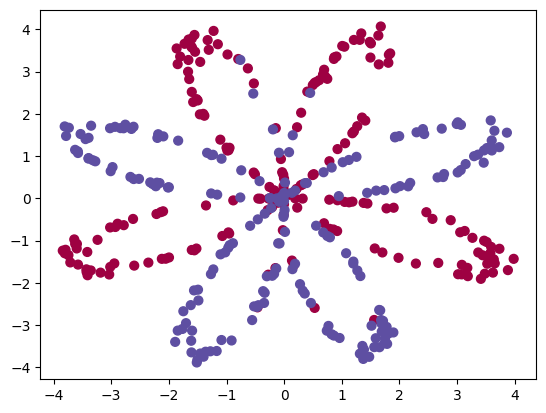

In [82]:
semilla = np.random.seed(66)
m = 400 # numero de ejemplos
X, Y = create_data(semilla, m)

# Visualizamos los datos:
plt.scatter(X[0, :], X[1, :], c=Y[0,:], s=40, cmap=plt.cm.Spectral)

Tenemos una matriz $X$ con los patrones ($X_1$, $X_2$), y un vector $Y$ con las etiquetas ($0=$*rojo*, $1=$*azul*).

Examinemos los datos a continuación.

### Ejercicio 2.1

Cuántos ejemplos de entrenamiento tenemos? O cuáles son las dimensiones (`shape`) de `X` e `Y`?

**Ayuda**: Recuerde cómo obtener la forma de un arreglo numpy [(ayuda)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html)

In [83]:
X.shape, Y.shape

((2, 400), (1, 400))

In [84]:
dim_X =
dim_Y =
m =                 # tamaño del conjunto de entrenamiento

print ('Las dimensiones de X son: ' + str(dim_X))
print ('Las dimensiones de Y son: ' + str(dim_Y))
print ('Hay m = %d ejemplos de entrenamiento' % (m))

Las dimensiones de X son: (2, 400)
Las dimensiones de Y son: (1, 400)
Hay m = 400 ejemplos de entrenamiento


**Salida esperada**:
       
<table style="width:40%">
<tr>
<td>Dimensiones de X</td>
<td> (2, 400) </td>
</tr>
<tr>
<td>Dimensiones de Y</td>
<td>(1, 400) </td>
</tr>
<tr>
<td>m</td>
<td> 400 </td>
</tr>
</table>

## 3 - Regresión Logística

Antes de contruir una red neuronal, primero estudiemos cómo se comporta la regresión logística con este problema. Podemos utilizar las funciones de sklearn para hacerlo. Ejecute el siguiente código para entrenar un clasificador de regresión logística sobre el conjunto de datos.

In [85]:
# Entrene el clasificador logístico
clf = sklearn.linear_model.LogisticRegressionCV(cv=5)
Y2=np.squeeze(Y)
clf.fit(X.T, Y2)

LogisticRegressionCV(cv=5)

Ahora se puede graficar la frontera de decisión para este modelo de acuerdo con la siguiente funcion:

In [86]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # grilla de puntos a una distancia h entre ellos
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # predice el valor de la funcion para toda la grilla
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # grafica el contorno y los ejemplos de entrenamiento
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)


Podemos ver la frontera de decisión mediante el siguiente código:

Exactitud de la regresión logística: 49.75% (porcentaje de puntos correctamente etiquetados)


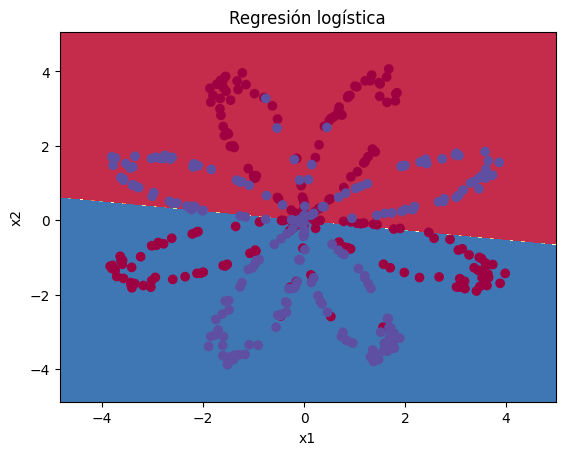

In [87]:
# Grafique la frontera de decisión para la regresión logística
plot_decision_boundary(lambda x: clf.predict(x), X, Y2)
plt.title("Regresión logística")

# Exactitud
LR_predictions = clf.predict(X.T)
exactitud = float((np.dot(Y2,LR_predictions) + np.dot(1-Y2,1-LR_predictions))/float(Y2.size)*100)
print(f"Exactitud de la regresión logística: {exactitud}% (porcentaje de puntos correctamente etiquetados)")

**Salida esperada**:

<table style="width:20%">
<tr>
<td>
Exactitud
</td>
<td> 49% </td>
</tr>
  
</table>

**Discusión**: como se esperaba, el conjunto de datos no es linealmente separable. Por esto, la regresión logística no logra un buen desempeño. Pero la red neuronal sí que debería lograr un mejor desempeño.  


## 4 - Modelo de red neuronal

La regresión logística no logró buenos resultados sobre el conjunto de datos. Por lo tanto, ahora vamos a entrenar una red neuronal con una sola capa escondida.

**Formulación matemática**:

Para un ejemplo $x^{(i)}$:

$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$

$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$

$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$

$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$

$$y^{(i)}_{prediccion} = \begin{cases} 1 & \mbox{si } a^{[2](i)} > 0.5 \\ 0 & \mbox{en caso contrario (e.c.c.) } \end{cases}\tag{5}$$

Dadas las predicciones sobre todos los ejemplos, computamos el coste $L$ de acuerdo con la función de entropía cruzada:
$$L = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Recuerde**: La metodología general para construir una red neuronal:
1. Definir una estructura de red neuronal ( Tamaño del input,  # de neuronas/unidades de decisión escondidas)
2. Inicializar los parámetros del modelo
3. Bucle:
   - Implementar propagación hacia delante
   - Computar la pérdida
   - Implementar la propagación hacia atrás mediante los gradientes
   - Actualizar los parámetros (Descenso en la dirección del gradiente: GD)

Se pueden construir funciones auxiliares para computar los pasos 1-3 y luego fusionarlas en una función global llamada `modelo_red()`. Una vez construida `modelo_red()` y habiendo aprendido los parámetros adecuados, se pueden hacer predicciones sobre nuevos datos.

### 4.1 - Definiendo la estructura de la red neuronal ####

### Ejercicio 4.1
Defina tres variables:
    - n_x: tamaño de la capa de entrada
    - n_h: tamaño de la capa oculta
    - n_y: tamaño de la capa de salida

Podemos utilizar las dimensiones de $X$ e $Y$ para encontrar $n_x$ y $n_y$.

In [88]:
def dim_capas(X, Y, num_neuronas):
    """
    Input:
    X: conjunto de datos de entrada, con dimensines (tamaño del input, número de ejemplos)
    Y: etiquetas (tamaño del output, número de ejemplos)
    Output:
    n_x: tamaño de la capa de entrada
    n_h: tamaño de la capa escondida
    n_y: tamaño de la capa de salida
    """
    n_x =       # tamaño de la capa de entrada
    n_h =       # número de neuronas en la capa escondida
    n_y =       # tamaño de la acapa de salida

    return (n_x, n_h, n_y)

In [89]:
num_neuronas = 4

(n_x, n_h, n_y) = dim_capas(X, Y, num_neuronas)
print("El tamaño de la capa de entrada es: n_x = " + str(n_x))
print("El tamaño de la capa de escondida es: n_h = " + str(n_h))
print("El tamaño de la capa de salida es: n_y = " + str(n_y))

El tamaño de la capa de entrada es: n_x = 2
El tamaño de la capa de escondida es: n_h = 4
El tamaño de la capa de salida es: n_y = 1


**Salida esperada**:  tenga en cuenta que esta comprobación es sólo para verificar que la función que ha programado es correcta. En la implemenatción de la red utilizaremos otras dimensiones.


<table style="width:20%">
<tr>
<td>n_x</td>
<td> 2 </td>
</tr>
<tr>
<td>n_h</td>
<td> 4 </td>
</tr>
<tr>
<td>n_y</td>
<td> 1 </td>
</tr>
</table>

### 4.2 - Inicialización de los parámetros del modelo

### Ejercicio 4.2

Ahora vamos a implementar la función `param_I()`.

**Paso a paso**:
- Debemos asegurarnos de que las dimensiones de los parámetros sean las correctas.
- Inicializamos los pesos con valores aleatorios.
    - Usamos `np.random.randn(a,b) * 0.01` para esta inicialización aleatoria de una matriz de dimensiones (a,b).
- Inicializamos los vectores de sesgo con ceros.
    - Usamos `np.zeros((a,b))` para la inicialización con ceros de la matriz de tamaño (a,b).

In [90]:
def param_I(n_x, n_h, n_y, semilla):
    """
    Input:
    n_x: tamaño de la capa de entrada
    n_h: tamaño de la capa escondida
    n_y: tamaño de la capa de salida
    Output:
    param: diccionario python con los parámetros:
            W1: matriz de pesos con dimensiones (n_h, n_x)
            b1: matriz de sesgos con dimensiones (n_h, 1)
            W2: matriz de pesos con dimensiones (n_y, n_h)
            b2: matriz de sesgos con dimensiones (n_y, 1)
    """
    np.random.seed(semilla)

    W1 =
    b1 =
    W2 =
    b2 =

    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))

    param = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
        }

    return param

In [91]:
param = param_I(n_x, n_h, n_y, semilla=2)
print("W1 = " + str(param["W1"]))
print("b1 = " + str(param["b1"]))
print("W2 = " + str(param["W2"]))
print("b2 = " + str(param["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


**Salida esperada**:

<table style="width:80%">
<tr>
<td>W</td>
<td> [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]] </td>
</tr>
<tr>
<td>b1</td>
<td> [[0.]
 [0.]
 [0.]
 [0.]] </td>
<tr>
<td>W2</td>
<td> [[-0.01057952 -0.00909008  0.00551454  0.02292208]] </td>
</tr>
<tr>
<td>b2</td>
<td> [[ 0.]] </td>
</tr>
</table>

### 4.3 - El bucle ####

### Propagación hacia delante

### Ejercicio 4.3.1
Implemente la propagación hacia delante `propagacion()`.

Ayuda: Puede usar la función `sigmoide()` que ya hemos programado anteriormente y la función `np.tanh()` (es parte de la biblioteca numpy).

- Los pasos que debe implementar son:
  1. Recupere cada parámetro del diccionario "param" (que es la salida de `param_I()`), utilizando `param[".."]`.
  2. Implemente la propagación hacia delante. Compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ y $A^{[2]}$ (el vector de todas sus predicciones sobre todos los ejemplos del conjunto de entrenamiento).
  
- Los valores necesarios para calcular la retro-propagación son guardados en "`memo`". Esta `memo` será proporcionada como entrada a la función de retro-propagación.

In [92]:
def sigmoide(x):
    s = 1/(1+np.exp(-x))
    return s


In [93]:
def propagacion(X, param):
    """
    Input:
    X: datos de entrada de tamaño (n_x, m)
    param: diccionario python con los parameters (salida de la funcion de inicialización)
    Output:
    A2: la salida de la función sigmoide de la segunda activación
    memo: un diccionario conteniendo "Z1", "A1", "Z2" y "A2"
    """
    # Recupera cada parámetro del diccionario "param"
    W1 =
    b1 =
    W2 =
    b2 =

    # Implemente la propagación hacia delante para calcular las probabilidades A2
    Z1 =
    A1 =
    Z2 =
    A2 =

    assert(A2.shape == (1, X.shape[1]))

    memo = {
        "Z1": ,
        "A1": ,
        "Z2": ,
        "A2":
        }

    return A2, memo

In [94]:
A2, memo = propagacion(X, param)

print(np.mean(memo['Z1']) ,np.mean(memo['A1']),np.mean(memo['Z2']),np.mean(memo['A2']))

0.0003756589777913734 0.00037584732210443043 2.533841178721172e-08 0.5000000063347811


**Salida esperada**:
<table style="width:90%">
<tr>
<td> 0.0003756589777913734 0.00037584732210443054 2.533841178721172e-08 0.5000000063347811
</td>
</tr>
</table>

### Función de pérdida

Ahora que ya hemos calculado $A^{[2]}$ (en la variable Python "`A2`"), con los valores  $a^{[2](i)}$ para cada ejemplo ($i$) podemos computar la función de coste:

$$L = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{7}$$

### Ejercicio 4.3.2
Implemente la función `perdida()` para calcular el valor de la pérdida $L$.


*Ayuda:*
Por ejemplo, la expresión $$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$$ se puede implementar de la siguiente manera:
```python
logprobs = np.multiply(np.log(A2),Y)
coste = - np.sum(logprobs)                
```
Puede usar tanto `np.multiply()` y luego `np.sum()`, como también `np.dot()`.


In [95]:
def perdida(A2, Y):
    """
    Computa la función de pérdida de entropía cruzada de la ecuación
    Input:
    A2: la salida de la función sigmoide para la segunda activación, de tamaño (1, numero de ejemplos)
    Y: vector de etiquetas de tamaño (1, numero de ejemplos)
    param: diccionario python con los parametros W1, b1, W2 and b2
    Ouput:
    coste: coste de entropía cruzada
    """

    m =         # numero de ejemplos

    # Coste de entropía cruzada
    logprobs =
    coste =

    coste =      # se asegura que el coste sea de la dimension esperada, e.g. un [[99]] lo torna en 99
    assert(isinstance(coste, float))

    return coste

In [96]:
print("coste = " + str(perdida(A2, Y)))

coste = 0.6930274319338173


**Salida esperada**:
<table style="width:40%">
<tr>
<td>coste</td>
<td> 0.6930274319338173 </td>
</tr>
</table>

### Retro-propagación

Ahora vamos a implementar el concepto más más importante de una red neuronal. Utilizando la memoria (`memo`) computada en la propagacion hacia delante, podemos implementar la propagación hacia atrás. Este paso nos permitirá actualizar la estimación de nuestros parámetros, es decir, paso a paso ir *aprendiendo* la frontera de decisión de acuerdo con los ejemplos de entrenamiento.

### Ejercicio 4.3.3

Implemente la función `retro()` para la **retro-propagación del error**

La retro-propagación suele ser la parte más difícil para la construcción de una red neuronal. Recordemos lo que es la retro-propagación. Se deben utilizar las seis ecuaciones siguientes


$\frac{\partial L }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})\tag{8}$

$\frac{\partial L }{ \partial W_2 } = \frac{\partial L }{ \partial z_{2}^{(i)} } a^{[1] (i) T} \tag{9}$

$\frac{\partial L }{ \partial b_2 } = \sum_i{\frac{\partial L }{ \partial z_{2}^{(i)}}}\tag{10}$

$\frac{\partial L }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial L }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2})\tag{11} $

$\frac{\partial L}{ \partial W_1 } = \frac{\partial L }{ \partial z_{1}^{(i)} }  X^T \tag{12}$

$\frac{\partial L }{ \partial b_1 } = \sum_i{\frac{\partial L }{ \partial z_{1}^{(i)}}} \tag{13}$

- Nótese que $*$ denota multiplicación por cada elemento.
- En el código utilizamos la siguiente notación:
    - dW1 = $\frac{\partial L }{ \partial W_1 }$
    - db1 = $\frac{\partial L }{ \partial b_1 }$
    - dW2 = $\frac{\partial L }{ \partial W_2 }$
    - db2 = $\frac{\partial L }{ \partial b_2 }$
    


- Ayuda:
    - Para computar dZ1 se debe calcular primero $g^{[1]'}(Z^{[1]})$. Como $g^{[1]}(.)$ es la función de activación tanh, si $a = g^{[1]}(z)$ entonces $g^{[1]'}(z) = 1-a^2$. Para mayores detalles puede ver: https://socratic.org/questions/what-is-the-derivative-of-tanh-x
    - Entonces puede calcular
    $g^{[1]'}(Z^{[1]})$ utilizando `(1 - np.power(A1, 2))`.
    - Tenga en cuenta las dimensiones correctas para la implementación de la propagación hacia atrás en el cálculo de $db$. Por ejemplo, para $db1$, si quiere sumar las columnas (filas), $axis=1$ ($axis=0$).
    - También tenga en cuenta que las dimensiones se pueden manetener fijas mediante el argumento $keepdims=True$.

In [97]:
def retro(param, memo, X, Y):
    """
    Implementa la retro-propagación del error
    Input:
    param: diccionario python con los parameteros
    memo: un diccionario con "Z1", "A1", "Z2" y "A2".
    X: datos de entrada
    Y: vector de etiquetas
    Output:
    grads: diccionario python con los gradientes de los diferentes parametros
    """
    m = X.shape[1]     # numero de ejemplos en X

    # Recuperamos los pesos W1 y W2 del diccionario "param".
    W1 =
    W2 =

    # Recuperamos A1 y A2 del diccionario "memo".
    A1 =
    A2 =

    # Retro-propagacion: calcula dW1, db1, dW2, db2.
    dZ2 = A2 - Y
    dW2 =
    db2 =
    dZ1 = np.dot(W2.T,dZ2) * (1 - np.power(A1,2))
    dW1 =
    db1 =

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads

In [98]:
grads = retro(param, memo, X, Y2)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[-0.00022872 -0.00278702]
 [-0.00018844 -0.00238845]
 [ 0.00012072  0.00145306]
 [ 0.00049226  0.00602335]]
db1 = [[ 1.02430069e-08]
 [ 2.36592378e-07]
 [-1.30321698e-07]
 [-1.50321903e-07]]
dW2 = [[-0.00023831  0.00386166 -0.00260686 -0.00316916]]
db2 = [[6.33478109e-09]]


**Salida esperada**:

<table style="width:80%">
<tr>
<td>dW1</td>
<td> [[-0.00022872 -0.00278702]
 [-0.00018844 -0.00238845]
 [ 0.00012072  0.00145306]
 [ 0.00049226  0.00602335]] </td>
</tr>
<tr>
<td>db1</td>
<td>  [[ 1.02430069e-08]
 [ 2.36592378e-07]
 [-1.30321698e-07]
 [-1.50321903e-07]] </td>
</tr>
<tr>
<td>dW2</td>
<td> [[-0.00023831  0.00386166 -0.00260686 -0.00316916]] </td>
</tr>
<tr>
<td>db2</td>
<td> [[6.33478109e-09]] </td>
</tr>
</table>  

### Actualización de parámetros

### Ejercicio 4.3.4

Implementamos la regla de actualización de nuestros estimadores dentro del GD. Usamos el método GD. Debe usar (dW1, db1, dW2, db2) para actualizar (W1, b1, W2, b2).


*Ayuda:* La regla general del GD consiste en definir $ \hat \theta_{nuevo} = \hat \theta_{viejo} - \alpha \frac{\partial L }{ \partial \hat \theta_{viejo} }$ donde $\alpha$ es la tasa de aprendizaje y $\theta$ representa un parámetro.




In [99]:
def rev_param(param, grads, tasa):
    """
    Actualice los parametros usando la regla de actualización del GD
    Input:
    param: diccionario python con los parametros
    grads: diccionario python con los gradientes
    Output:
    param: diccionario python con los parametros actualizados
    """
    # Los parametros del diccionario "param"
    W1 =
    b1 =
    W2 =
    b2 =

    # Los gradientes del diccionario "grads"
    dW1 =
    db1 =
    dW2 =
    db2 =

    # Regla de actualización para cada parametro
    W1 =
    b1 =
    W2 =
    b2 =

    param = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

    return param

In [100]:
param = rev_param(param, grads, tasa=1.2)

print("W1 = " + str(param["W1"]))
print("b1 = " + str(param["b1"]))
print("W2 = " + str(param["W2"]))
print("b2 = " + str(param["b2"]))

W1 = [[-0.00389312  0.00278176]
 [-0.02113583  0.01926884]
 [-0.01807922 -0.01016114]
 [ 0.0044381  -0.0196809 ]]
b1 = [[-1.22916083e-08]
 [-2.83910854e-07]
 [ 1.56386037e-07]
 [ 1.80386284e-07]]
W2 = [[-0.01029355 -0.01372407  0.00864277  0.02672507]]
b2 = [[-7.60173731e-09]]


**Salida esperada**:

<table style="width:80%">
<tr>
<td>W1</td>
<td> [[-0.00389312  0.00278176]
 [-0.02113583  0.01926884]
 [-0.01807922 -0.01016114]
 [ 0.0044381  -0.0196809 ]]</td>
</tr>
<tr>
<td>b1</td>
<td> [[-1.22916083e-08]
 [-2.83910854e-07]
 [ 1.56386037e-07]
 [ 1.80386284e-07]]</td>
</tr>
<tr>
<td>W2</td>
<td> [[-0.01029355 -0.01372407  0.00864277  0.02672507]] </td>
</tr>
<tr>
<td>b2</td>
<td> [[-7.60173731e-09]] </td>
</tr>
</table>  

### 4.4 - Combinacion de funciones

Ahora integramos las partes 4.1, 4.2 y 4.3 en modelo_red()

### Ejercicio
Construya su modelo de red neuronal en `modelo_red()`.

El modelo de la red debe usar las funciones previamente construidas en el orden correcto.

In [101]:
def modelo_red(X, Y, n_h, num_iter, tasa, print_c, semilla):
    """
    Input:
    X: datos de entrada
    Y: vector de etiquetas
    n_h: tamaño de la capa escondida
    num_iter: numero de iteraciones del bucle del GD
    tasa: tasa de aprendizaje
    print_c: si "True", muestra el coste cada 1000 iteraciones
    semilla: semilla aleatoria
    Output:
    param: parametros aprendidos para el modelo final. Se utilizan para la predicción
    """

    n_x = dim_capas(X, Y, n_h)[0]
    n_y = dim_capas(X, Y, n_h)[2]

    # Inicializa los parámetros y carga W1, b1, W2, b2.
    # Inputs: "n_x, n_h, n_y, semilla". Outputs = "W1, b1, W2, b2, parametros".
    param = param_I(n_x, n_h, n_y, semilla)
    W1 = param["W1"]
    b1 = param["b1"]
    W2 = param["W2"]
    b2 = param["b2"]

    # Bucle (GD)
    for i in range(0, num_iter):

        # Propagación hacia delante.
        # Inputs: "X, param". Outputs: "A2, memo".
        A2, memo =

        # Función de coste.
        # Inputs: "A2, Y, param". Outputs: "coste".
        coste =

        # Retro-propagacion.
        # Inputs: "param, memo, X, Y". Outputs: "grads".
        grads =

        # Actualizacion de parametros por GD.
        # Inputs: "param, grads, tasa". Outputs: "param".
        param =


        # Muestre el coste cada 1000 iteraciones
        if print_c and i % 1000 == 0:
            print ("Coste tras la iteración %i: %f" %(i, coste))

    return param

In [102]:
param = modelo_red(X, Y, n_h=4, num_iter=10000, tasa=2.5, print_c=True, semilla=0)
print("W1 = " + str(param["W1"]))
print("b1 = " + str(param["b1"]))
print("W2 = " + str(param["W2"]))
print("b2 = " + str(param["b2"]))

Coste tras la iteración 0: 0.693165
Coste tras la iteración 1000: 0.212300
Coste tras la iteración 2000: 0.204700
Coste tras la iteración 3000: 0.202225
Coste tras la iteración 4000: 0.201530
Coste tras la iteración 5000: 0.201157
Coste tras la iteración 6000: 0.200892
Coste tras la iteración 7000: 0.200672
Coste tras la iteración 8000: 0.200473
Coste tras la iteración 9000: 0.200288
W1 = [[ 2.03148475 -5.88145052]
 [ 8.20919932  9.54151733]
 [ 6.29284472 -7.35005328]
 [ 0.18184978 16.37649085]]
b1 = [[ 2.21378877]
 [ 0.11075761]
 [ 0.28745663]
 [-0.01307817]]
W2 = [[-1.44300424 -7.08129915  5.60226182  8.89983919]]
b2 = [[-0.03814532]]


**Salida esperada**:

<table style="width:90%">
<tr>
<td>  coste tras la iteracion 1000
</td>
<td> 0.212237
</td>
</tr>
<tr>
<td>
<center> $\vdots$ </center>
</td>
<td>
<center> $\vdots$ </center>
</td>
</tr>
<tr>
<td>W1</td>
<td> [[ 2.03147148 -5.88139449]
 [ 8.20917502  9.54149218]
 [ 6.29283248 -7.35003994]
 [ 0.18185045 16.37644482]]</td>
</tr>
<tr>
<td>b1</td>
<td> [[ 2.21377078]
 [ 0.11075722]
 [ 0.28745752]
 [-0.01307749]] </td>
</tr>
<tr>
<td>W2</td>
<td> [[-1.44301402 -7.0813084   5.6022717   8.89984852]] </td>
</tr>
<tr>
<td>b2</td>
<td> [[-0.03814504]] </td>
</tr>
</table>  

### 4.5 Predicciones

Ahora que tenemos nuestro código completo para la implementación de una red de red neuronal sencilla, podemos utilizarlo para predecir la clase de nuevas observaciones. Pero antes debemos convertir las probabilidades de nuestro modelo en predicciones nítidas para asignar la clase.

### Ejercicio 4.5.1
Especifique la funcion pred(), la cual haga uso de la propagacion hacia delante para predecir la clase.

La función que queremos implementar:

$y_{prediccion} = \begin{cases}
      1 & \text{si }\ activacion > 0.5 \\
      0 & \text{$e.c.c.$}
    \end{cases}$  

    
Como un ejemplo, si quiere fijar las entradas de una matriz de X a 0 y 1 basados en un $umbral$, se puede hacer de la siguiente manera: $$X_{nuevo} = (X > umbral)$$

In [103]:
def pred(param, X):
    """
    Usando las estimaciones de los parámetros, predice una clase para cada ejemplo de X
    Input:
    param: diccionario python con los parametros
    X: datos de entrada de tamaño (n_x, m)
    Output:
    prediccion: vector de predicciones para el modelo (rojo: 0 / azul: 1)
    """

    # Compute las probabilidades usando propagacion hacia delante, y clasifica a 0/1 usando 0.5 como umbral.
    A2, memo =
    prediccion =

    return prediccion

In [104]:
prediccion = pred(param, X)
print("Predicción media = " + str(np.mean(prediccion)))

Predicción media = 0.5


**Salida esperada**:

<table style="width:40%">
<tr>
<td>Predicción media</td>
<td> 0.5 </td>
</tr>
</table>

Ahora podemos ejecutar el modelo y ver su desempeño sobre el conjunto de datos inicial.

### Ejercicio 4.5.2
Ejecute el siguiente código para probar el modelo con una sola capa escondida de $n_h=10$ neuronas/unidades escondidas, 10000 iteraciones y una tasa de aprendizaje de 0.01.

Coste tras la iteración 0: 0.693149
Coste tras la iteración 1000: 0.677590
Coste tras la iteración 2000: 0.658924
Coste tras la iteración 3000: 0.635631
Coste tras la iteración 4000: 0.600104
Coste tras la iteración 5000: 0.579707
Coste tras la iteración 6000: 0.562551
Coste tras la iteración 7000: 0.498844
Coste tras la iteración 8000: 0.411819
Coste tras la iteración 9000: 0.361672


Text(0.5, 1.0, 'Frontera de decisión para una capa escondida de tamaño  10')

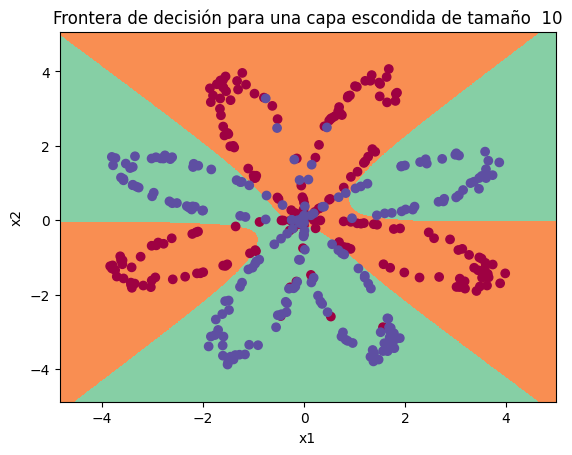

In [105]:
# Construya un modelo con una capa escondida de dimensión $n_h=10$
seed=39

n_h=10
param = modelo_red(X, Y, n_h, num_iter = 10000, tasa=0.01, print_c=True, semilla=seed)

# Grafique la frontera de decisión
plot_decision_boundary(lambda x: pred(param, x.T), X, Y2)
plt.title("Frontera de decisión para una capa escondida de tamaño  " + str(n_h))

**Salida esperada**:

<table style="width:50%">
<tr>
<td>Coste tras la iteración 9000</td>
<td> 0.361672 </td>
</tr>
</table>

Veamos la EXACTITUD del modelo:

In [ ]:
# Mostramos la exactitud
prediccion = pred(param, X)
exactitud = np.squeeze((np.dot(Y,prediccion.T) + np.dot(1-Y,1-prediccion.T))/float(Y.size)*100)
print(f'Exactitud: {exactitud}%')

**Salida esperada**:

<table style="width:35%">
<tr>
<td>Exactitud</td>
<td> 90% </td>
</tr>
</table>

Ahora veamos la accuracy en prediccion con nuevos datos:

In [107]:
semilla=999  #tomamos una semilla distinta
m = 400 # numero de ejemplos

X_prueba, Y_prueba = create_data(semilla,m)

# Accuracy de prueba
pred_prueba = pred(param, X_prueba)
exactitud = np.squeeze((np.dot(Y_prueba,pred_prueba.T) + np.dot(1-Y_prueba,1-pred_prueba.T))/float(Y_prueba.size)*100)
print (f'Exactitud: {exactitud}%')

Exactitud: 87.75%


**Salida esperada**:

<table style="width:35%">
  <tr>
    <td>Exactitud</td>
    <td> 87% </td>
  </tr>
</table>

La exactitud ($accuracy$) es alta comparada con los resultados de la regresión logística. El modelo de red neuronal sencilla ha aprendido a generalizar el comportameinto de $Y$ sobre los datos de la muestra.

Hemos podido verificar que las redes neuronales pueden aprender fronteras de decisión en alto grado no-lineales, a diferencia de la regresión logística.

Ahora, encontremos el mejor modelo al intentar distintos tamaños de la capa escondida.

### Ejercicio 4.5.3

Mediante un conjunto de posibles tamaños para la capa escondida (numero de neuronas en la capa escondida): num_neuronas = [1, 2, .. , H], encuentre el valor que logre el mejor ajuste sobre los datos de entrenamiento.

Analize los distintos comportamientos del modelo para distintos tamaños de la capa escondida.

Coste tras la iteración 0: 0.693146
Coste tras la iteración 1000: 0.609968
Coste tras la iteración 2000: 0.608201
Coste tras la iteración 3000: 0.607236
Coste tras la iteración 4000: 0.606594
Coste tras la iteración 5000: 0.606128
Coste tras la iteración 6000: 0.605774
Coste tras la iteración 7000: 0.605494
Coste tras la iteración 8000: 0.605268
Coste tras la iteración 9000: 0.605080


<ipython-input-108-5cd7b53da9ac>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Exactitud = float((np.dot(Y,prediccion.T) + np.dot(1-Y,1-prediccion.T))/float(Y.size)*100)


Exactitud para 1 unidades escondidas: 70.75 %
Coste tras la iteración 0: 0.693178
Coste tras la iteración 1000: 0.534976
Coste tras la iteración 2000: 0.531590
Coste tras la iteración 3000: 0.529949
Coste tras la iteración 4000: 0.528940
Coste tras la iteración 5000: 0.528250
Coste tras la iteración 6000: 0.527747
Coste tras la iteración 7000: 0.527363
Coste tras la iteración 8000: 0.527059
Coste tras la iteración 9000: 0.526813
Exactitud para 2 unidades escondidas: 69.75 %
Coste tras la iteración 0: 0.693207
Coste tras la iteración 1000: 0.228591
Coste tras la iteración 2000: 0.218436
Coste tras la iteración 3000: 0.214547
Coste tras la iteración 4000: 0.212035
Coste tras la iteración 5000: 0.210157
Coste tras la iteración 6000: 0.208684
Coste tras la iteración 7000: 0.207502
Coste tras la iteración 8000: 0.206536
Coste tras la iteración 9000: 0.205731
Exactitud para 3 unidades escondidas: 92.25 %
Coste tras la iteración 0: 0.693116
Coste tras la iteración 1000: 0.225926
Coste tras la

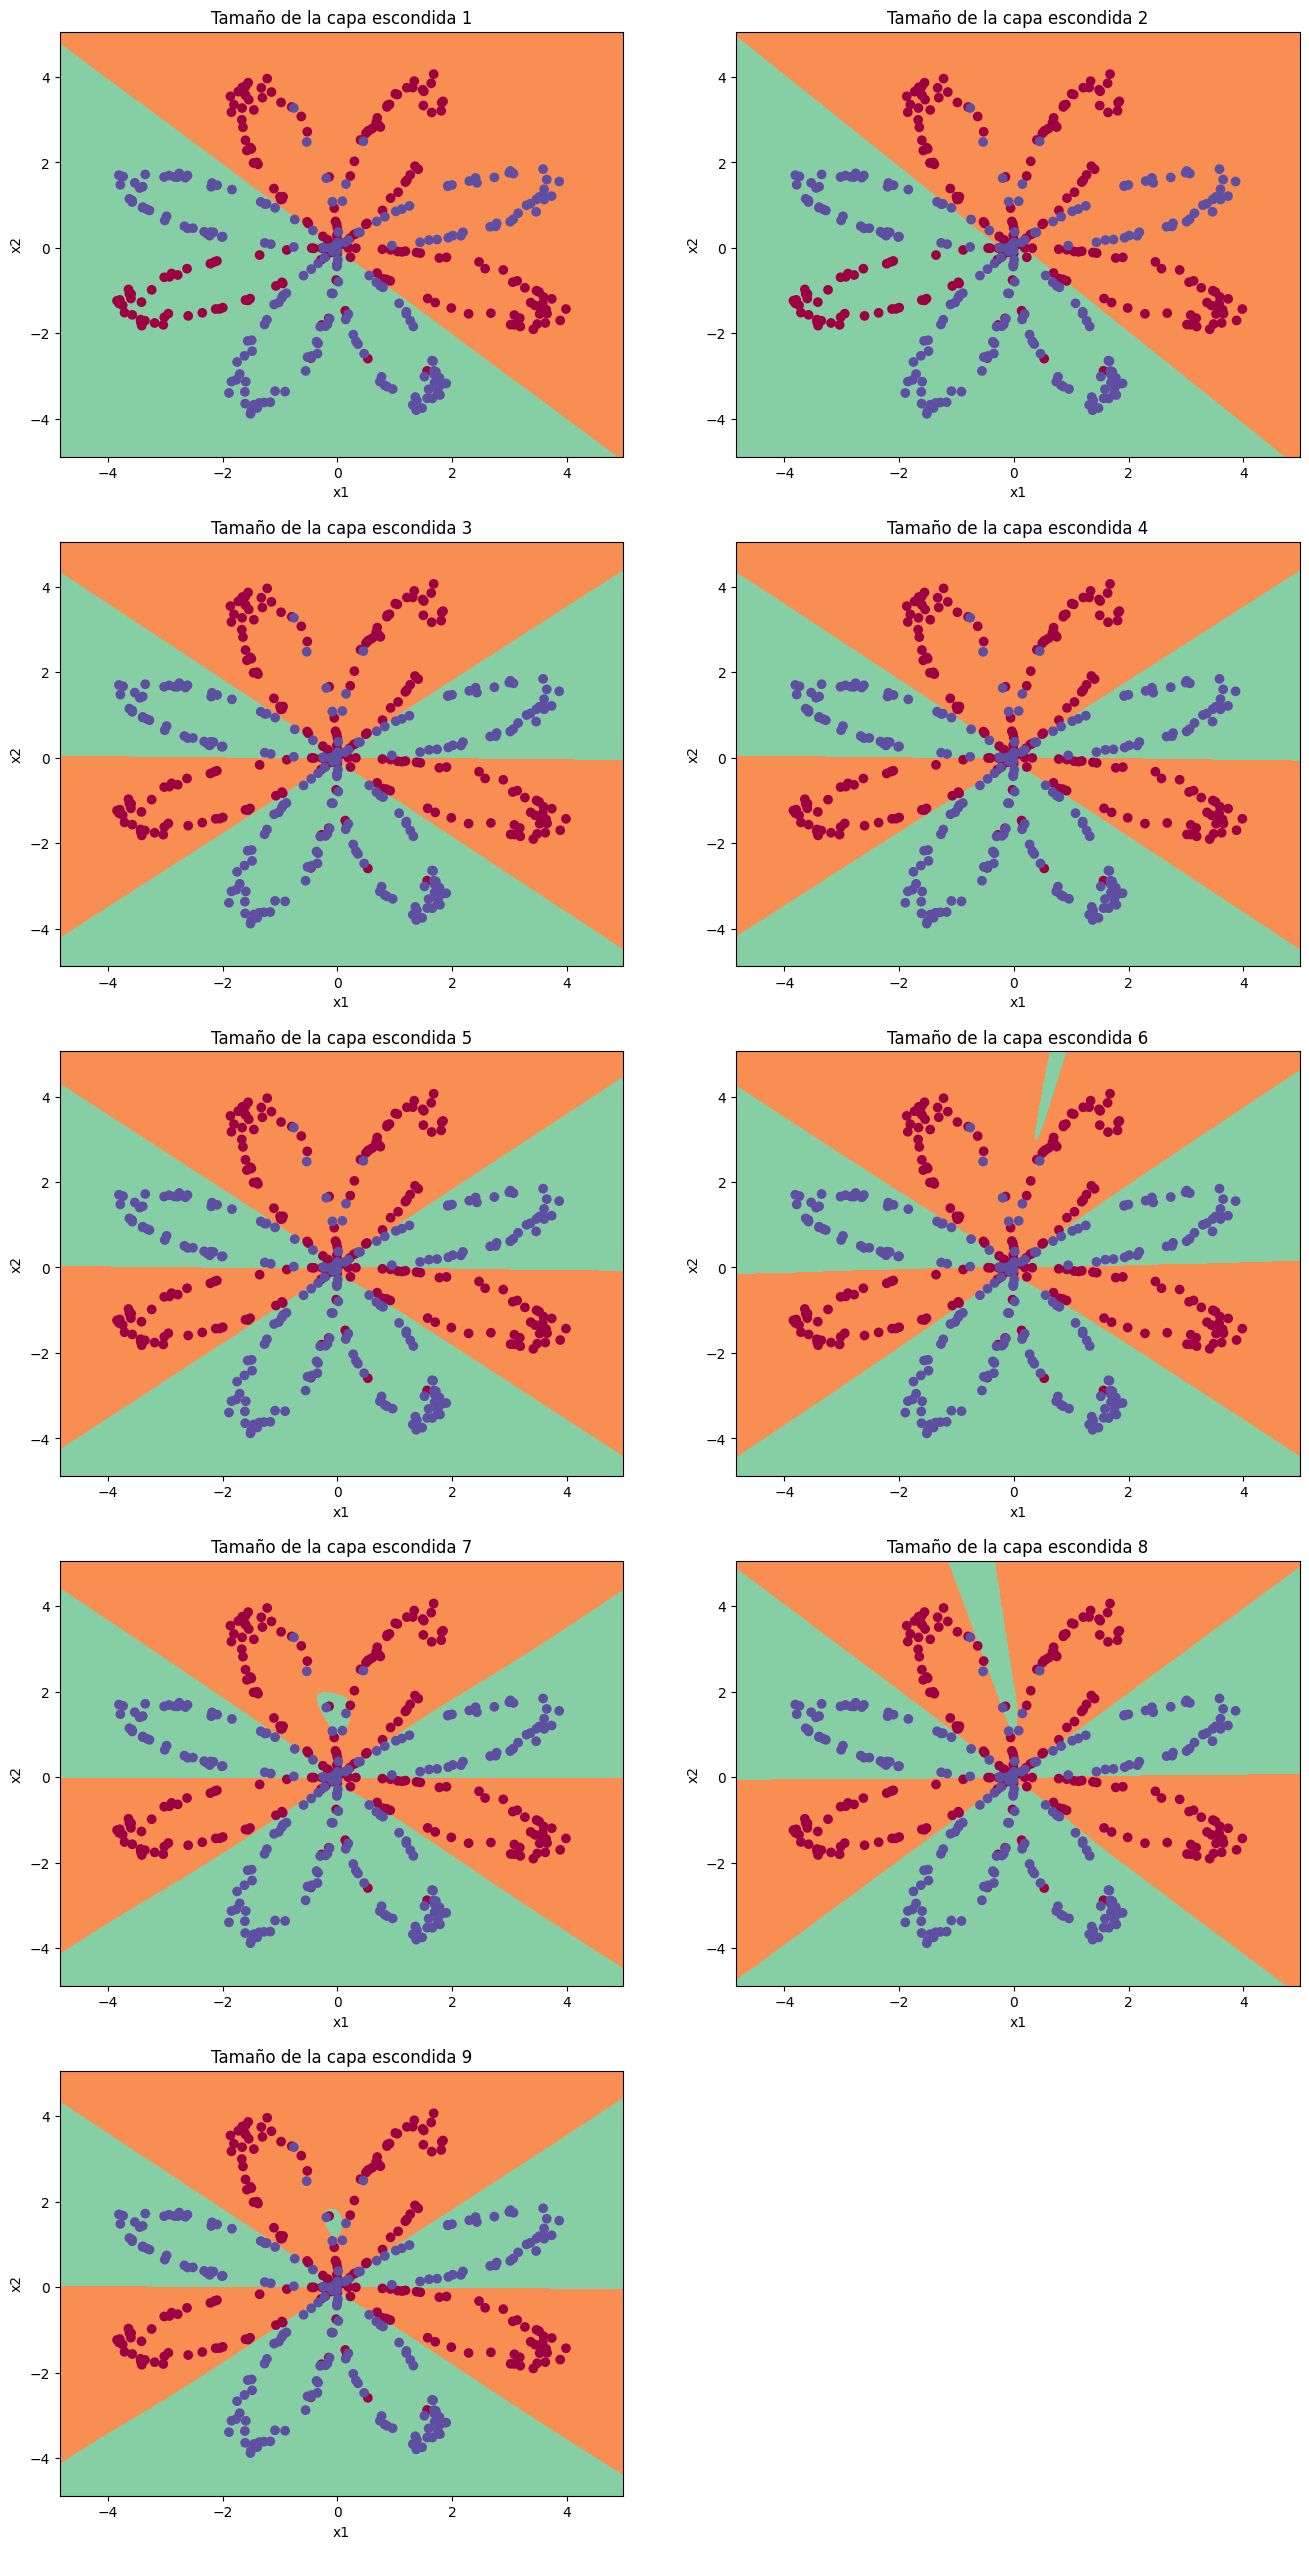

In [108]:
plt.figure(figsize=(16, 32))

num_neuronas = np.arange(1,10)   #

for i, n_h in enumerate(num_neuronas):
    plt.subplot(5, 2, i+1)
    plt.title(f'Tamaño de la capa escondida {n_h}')
    param = modelo_red(X, Y, n_h, num_iter = 10000, tasa=1, print_c=True, semilla=13)
    plot_decision_boundary(lambda x: pred(param, x.T), X, Y2)
    prediccion = pred(param, X)
    Exactitud = float((np.dot(Y,prediccion.T) + np.dot(1-Y,1-prediccion.T))/float(Y.size)*100)
    print(f"Exactitud para {n_h} unidades escondidas: {Exactitud} %")

**Discusión**:
- Modelos más complejos (con más unidades escondidas) logran un mejor ajuste al conjunto de entrenamiento, hasta que eventualmente los modelos más grandes se *sobreajustan* a los datos.

### Pregunta 4.5.4

¿Cuál es la mejor configuración del modelo?

Recuerde: el mejor modelo es aquel que logre una mejor generalización de los datos.



**R/.** De acuerdo con la información gráfica, la estructura con 5 neuronas, sería aquella que tiene una mejor generalización de los datos, aunque el uso de 6 neuronas muestra el valor más alto de exactitud, existe una zona azul que identifica una clasificación para la cual no hay ninguna observación. De todos modos aumentaremos el número de neuronas a probar.

Coste tras la iteración 0: 0.693099
Coste tras la iteración 1000: 0.227395
Coste tras la iteración 2000: 0.218331
Coste tras la iteración 3000: 0.214095
Coste tras la iteración 4000: 0.211395
Coste tras la iteración 5000: 0.209480
Coste tras la iteración 6000: 0.207968
Coste tras la iteración 7000: 0.206152
Coste tras la iteración 8000: 0.203611
Coste tras la iteración 9000: 0.202748


<ipython-input-32-da20c41026ae>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Exactitud = float((np.dot(Y,prediccion.T) + np.dot(1-Y,1-prediccion.T))/float(Y.size)*100)


Exactitud para 5 unidades escondidas: 93.25 %
Coste tras la iteración 0: 0.693211
Coste tras la iteración 1000: 0.217954
Coste tras la iteración 2000: 0.194726
Coste tras la iteración 3000: 0.159285
Coste tras la iteración 4000: 0.149923
Coste tras la iteración 5000: 0.145643
Coste tras la iteración 6000: 0.142886
Coste tras la iteración 7000: 0.140858
Coste tras la iteración 8000: 0.139228
Coste tras la iteración 9000: 0.137790
Exactitud para 10 unidades escondidas: 94.25 %
Coste tras la iteración 0: 0.692962
Coste tras la iteración 1000: 0.219970
Coste tras la iteración 2000: 0.184272
Coste tras la iteración 3000: 0.158112
Coste tras la iteración 4000: 0.149584
Coste tras la iteración 5000: 0.144905
Coste tras la iteración 6000: 0.140915
Coste tras la iteración 7000: 0.137541
Coste tras la iteración 8000: 0.134809
Coste tras la iteración 9000: 0.132627
Exactitud para 15 unidades escondidas: 95.0 %
Coste tras la iteración 0: 0.693159
Coste tras la iteración 1000: 0.215134
Coste tras l

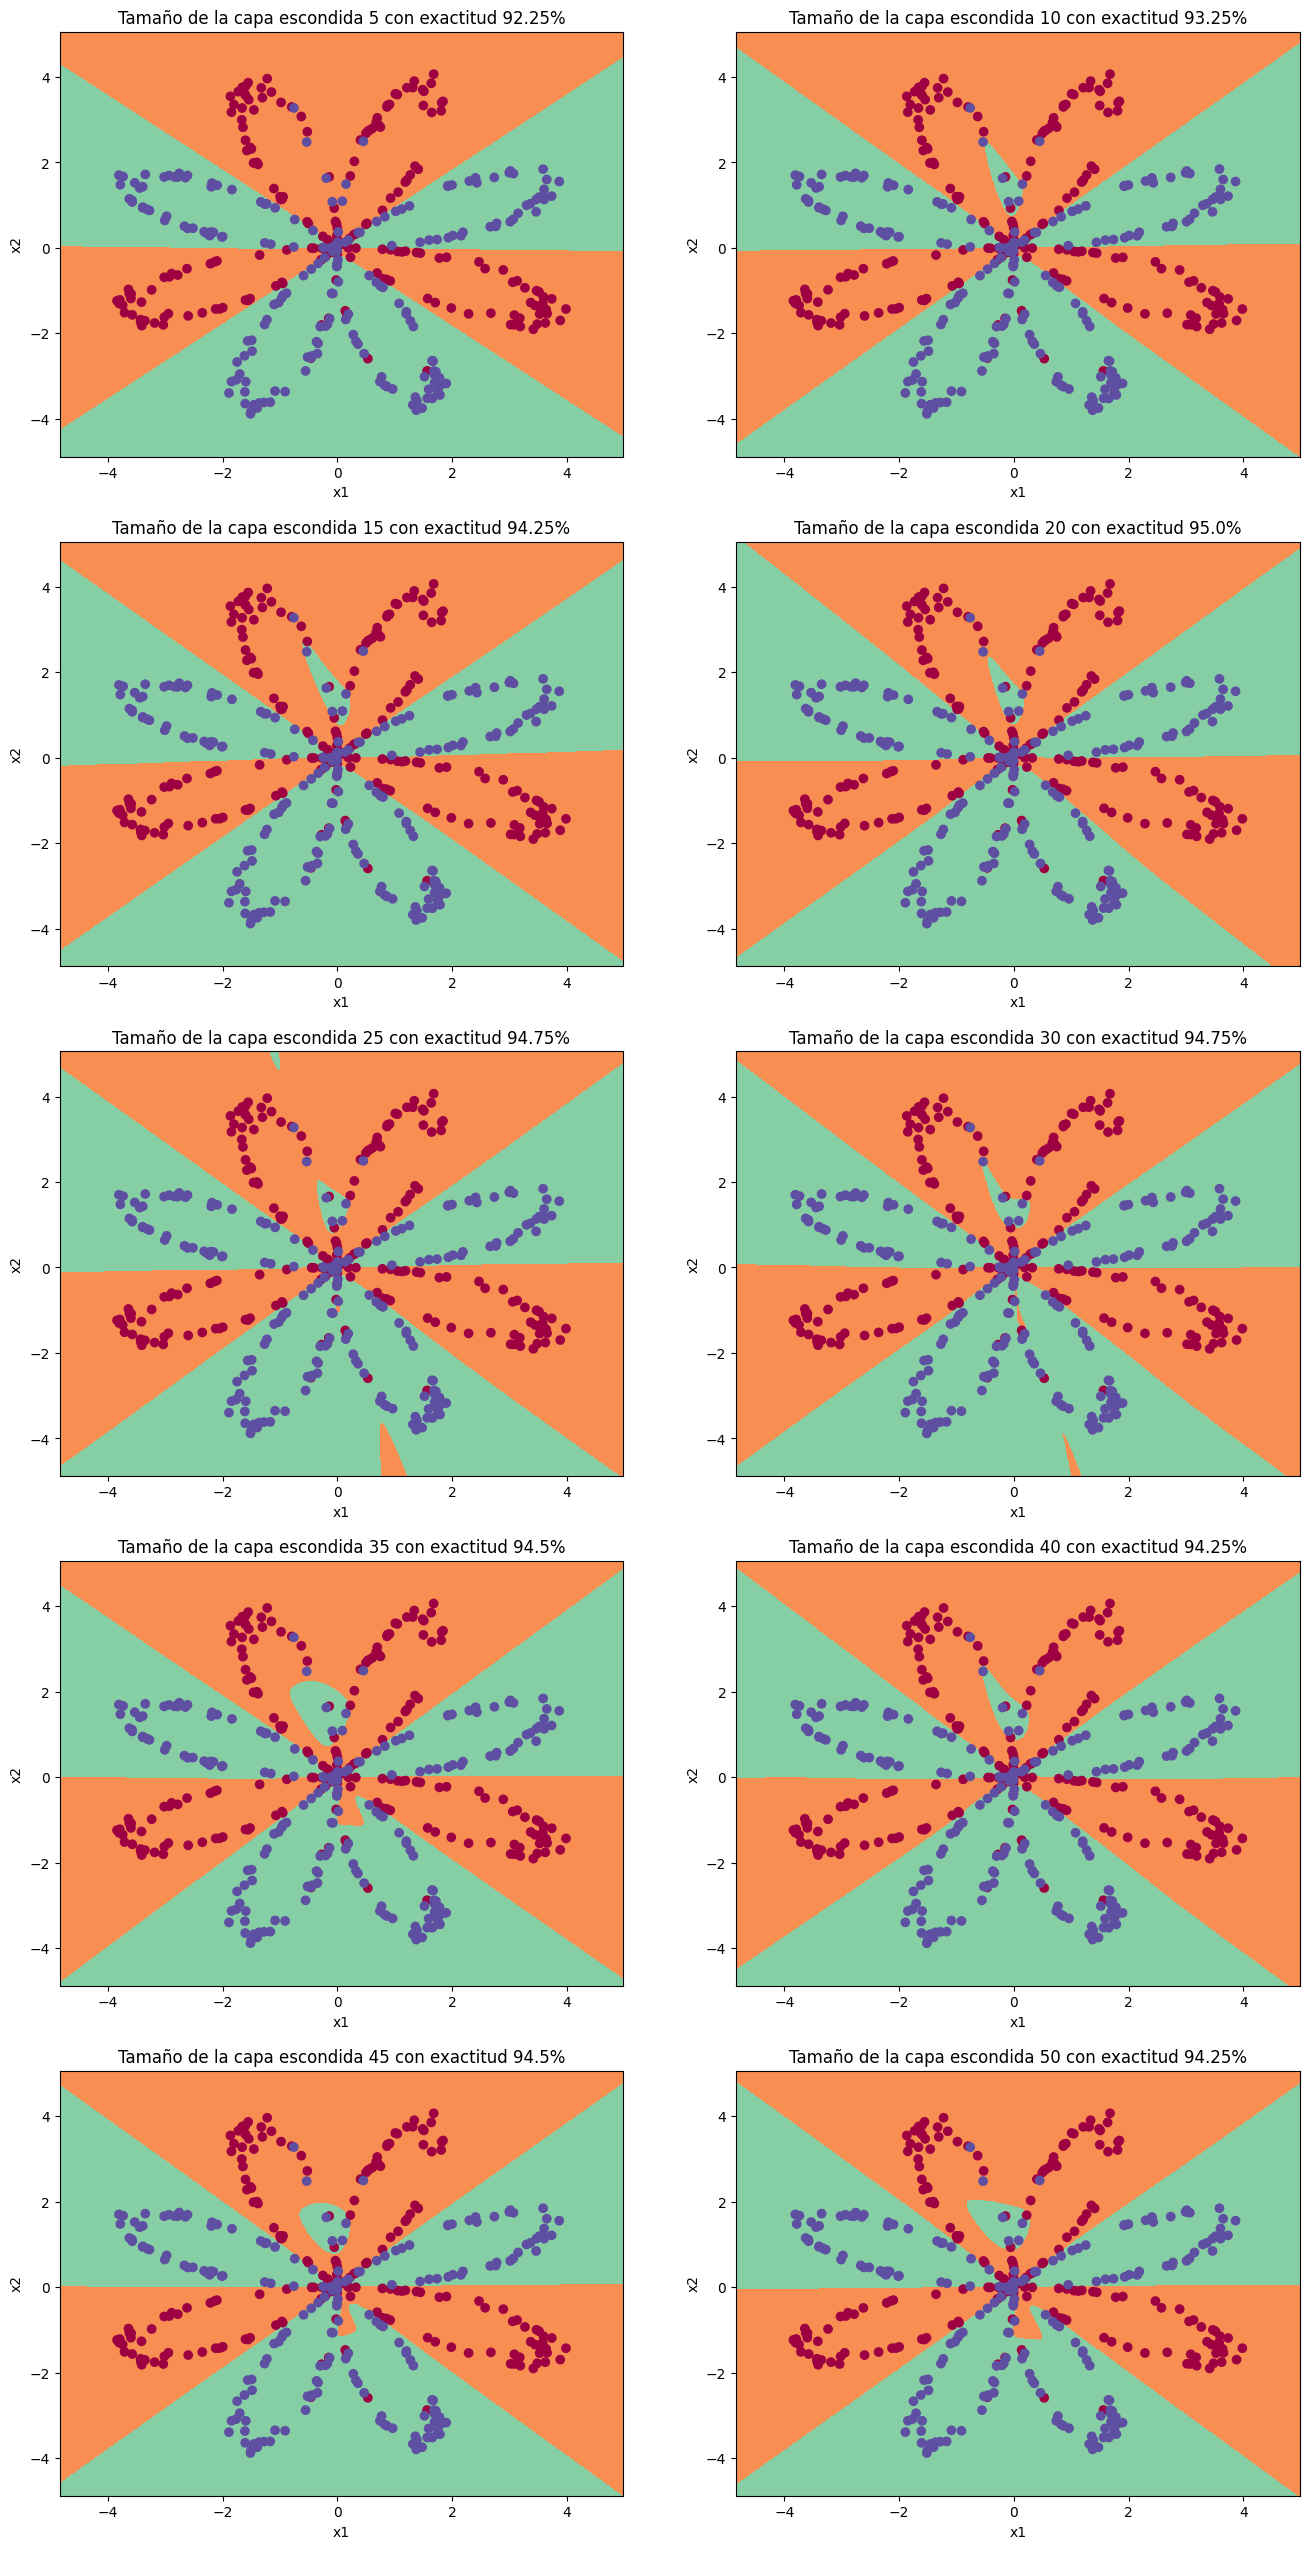

In [32]:
plt.figure(figsize=(16, 32))

num_neuronas = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]   #

for i, n_h in enumerate(num_neuronas):
    plt.subplot(5, 2, i+1)
    plt.title(f'Tamaño de la capa escondida {n_h} con exactitud {Exactitud}%')
    param = modelo_red(X, Y, n_h, num_iter = 10000, tasa=1, print_c=True, semilla=13)
    plot_decision_boundary(lambda x: pred(param, x.T), X, Y2)
    prediccion = pred(param, X)
    Exactitud = float((np.dot(Y,prediccion.T) + np.dot(1-Y,1-prediccion.T))/float(Y.size)*100)
    print(f"Exactitud para {n_h} unidades escondidas: {Exactitud} %")

### Pregunta 4.5.5

¿Qué ocurre si cambiamos la función de activación en la capa de salida de sigmoide a ReLU?

In [109]:
def ReLu(x):
    s =
    return s

In [112]:
def propagacion(X, param):
    """
    Input:
    X: datos de entrada de tamaño (n_x, m)
    param: diccionario python con los parameters (salida de la funcion de inicialización)
    Output:
    A2: la salida de la función sigmoide de la segunda activación
    memo: un diccionario conteniendo "Z1", "A1", "Z2" y "A2"
    """
    # Recupera cada parámetro del diccionario "param"
    W1 =
    b1 =
    W2 =
    b2 =

    # Implemente la propagación hacia delante para calcular las probabilidades A2
    Z1 =
    A1 =
    Z2 =
    A2 =

    assert(A2.shape == (1, X.shape[1]))

    memo = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return A2, memo

<ipython-input-95-baaefc4289e1>:15: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(Y,np.log(A2)) + np.multiply(1-Y,np.log(1-A2))
<ipython-input-95-baaefc4289e1>:15: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(Y,np.log(A2)) + np.multiply(1-Y,np.log(1-A2))


Coste tras la iteración 0: nan
Coste tras la iteración 1000: 0.661898
Coste tras la iteración 2000: 0.655023
Coste tras la iteración 3000: 0.654232
Coste tras la iteración 4000: 0.653522
Coste tras la iteración 5000: 0.652436
Coste tras la iteración 6000: 0.650133
Coste tras la iteración 7000: 0.644525
Coste tras la iteración 8000: 0.631255
Coste tras la iteración 9000: 0.607944


Text(0.5, 1.0, 'Frontera de decisión para una capa escondida de tamaño  10')

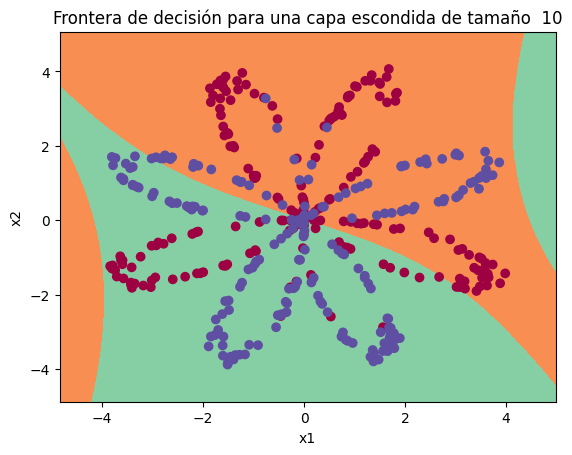

In [116]:
# Construya un modelo con una capa escondida de dimensión $n_h=10$
seed=39

param = modelo_red(X, Y, n_h=10, num_iter = 10000, tasa=0.01, print_c=True, semilla=seed)

# Grafique la frontera de decisión
plot_decision_boundary(lambda x: pred(param, x.T), X, Y2)
plt.title("Frontera de decisión para una capa escondida de tamaño  " + str(n_h))

In [ ]:
# Mostramos la exactitud
prediccion =
exactitud = np.squeeze((np.dot(Y,prediccion.T) + np.dot(1-Y,1-prediccion.T))/float(Y.size)*100)
print(f'Exactitud: {exactitud}')

In [ ]:
semilla=999  #tomamos una semilla distinta
m = 400 # numero de ejemplos

X_prueba, Y_prueba = create_data(semilla,m)

# Accuracy de prueba
pred_prueba = pred(param, X_prueba)
exactitud = np.squeeze((np.dot(Y_prueba,pred_prueba.T) + np.dot(1-Y_prueba,1-pred_prueba.T))/float(Y_prueba.size)*100)
print(f'Exactitud: {exactitud}%')

Felicitaciones, ha llegado al final de la actividad, estudiando en detalle conceptos clave para calibrar un modelo de red neuronal. Para finalizar, a continuación veamos un caso de estudio con imagenes. Vamos a probar una red neuronal sencilla para la deteccion automática de plantas nativas a partir de imagenes aereas del paramo de Chingaza y Cruz Verde.

Este caso de estudio hace parte de un proyecto de Ingeniería que busca preservar y monitorizar el ecosistema del páramo, de gran importancia por su potencial hídrico, mediante la propuesta de una metodología para la reconstrucción del ecosistema en zonas de baja densidad de poblaciones de la especia *Espeletia*.